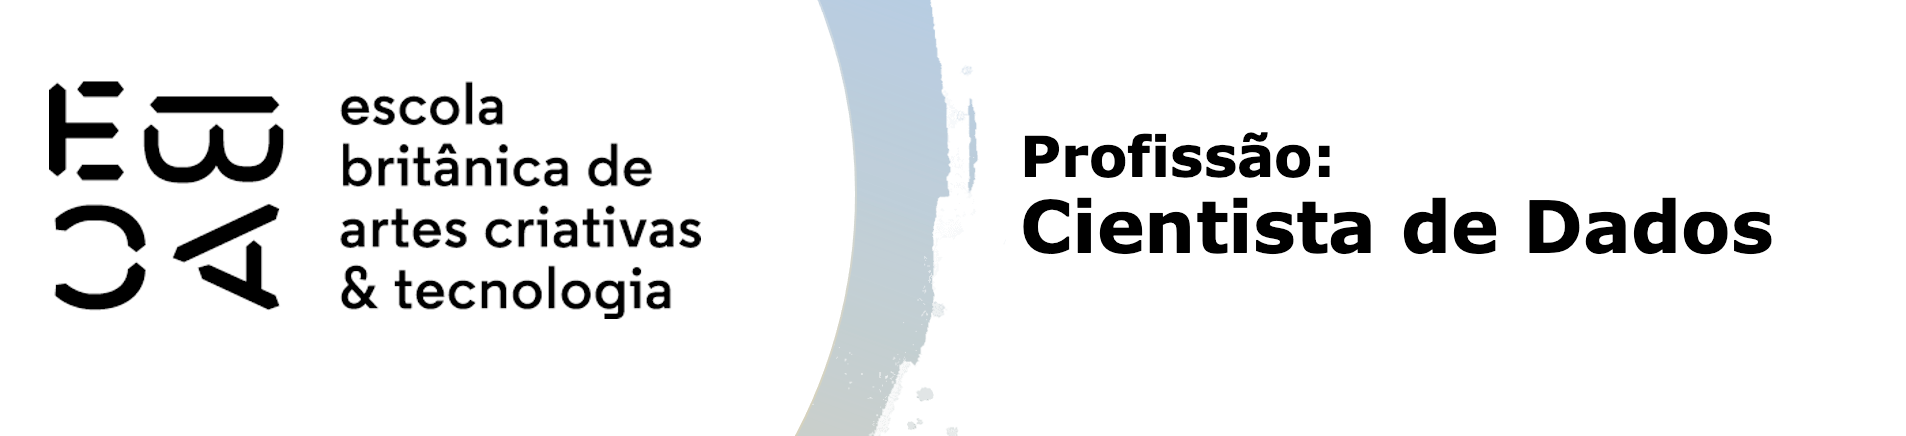

# Métodos hierárquicos de agrupamento

## Objetivos

O objetivo desta aula é ter um primeiro contato com os comandos desse método e ver seus resultados de forma bem pragmática. Em seguida vamos entrar nos detalhes do algoritmo, diferenças para o *k-means*, hiperparâmetros, etc.

In [67]:
import time as time
from gower import gower_matrix

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn                 import datasets
from sklearn.preprocessing   import StandardScaler
from sklearn.cluster         import AgglomerativeClustering
from sklearn.cluster         import KMeans
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from scipy.spatial           import distance
from scipy.spatial.distance  import pdist, squareform
from scipy.cluster           import hierarchy as shc
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

## Carregando a base de dados

Vamos carregar a base de dados ```penguins``` com a ajuda do Seaborn. Vamos também fazer um tratamento bem simples:
- Nomear o índice, para podermos voltar a informação dos agrupamentos na base original - vamos usar esse índice como chave, para isso ele deve ter um nome.
- Eliminar valores missing nas variáveis quantitativas.

In [3]:
peng = sns.load_dataset('penguins')
peng.index.name='id'
peng_num = peng.select_dtypes(include='number').dropna()

## Visualização dos dados

O gráfico de dispersão nos mostra os dados que vamos ajustar, colorido pela espécie. Lembrando que embora as espécies mostrem agrupamentos naturais nessa base de dados, não queremos classificar os dados nas espécies, mas sim encontrar padrões naturais - que se coincidirem com as espécies será somente uma feliz coincidência.

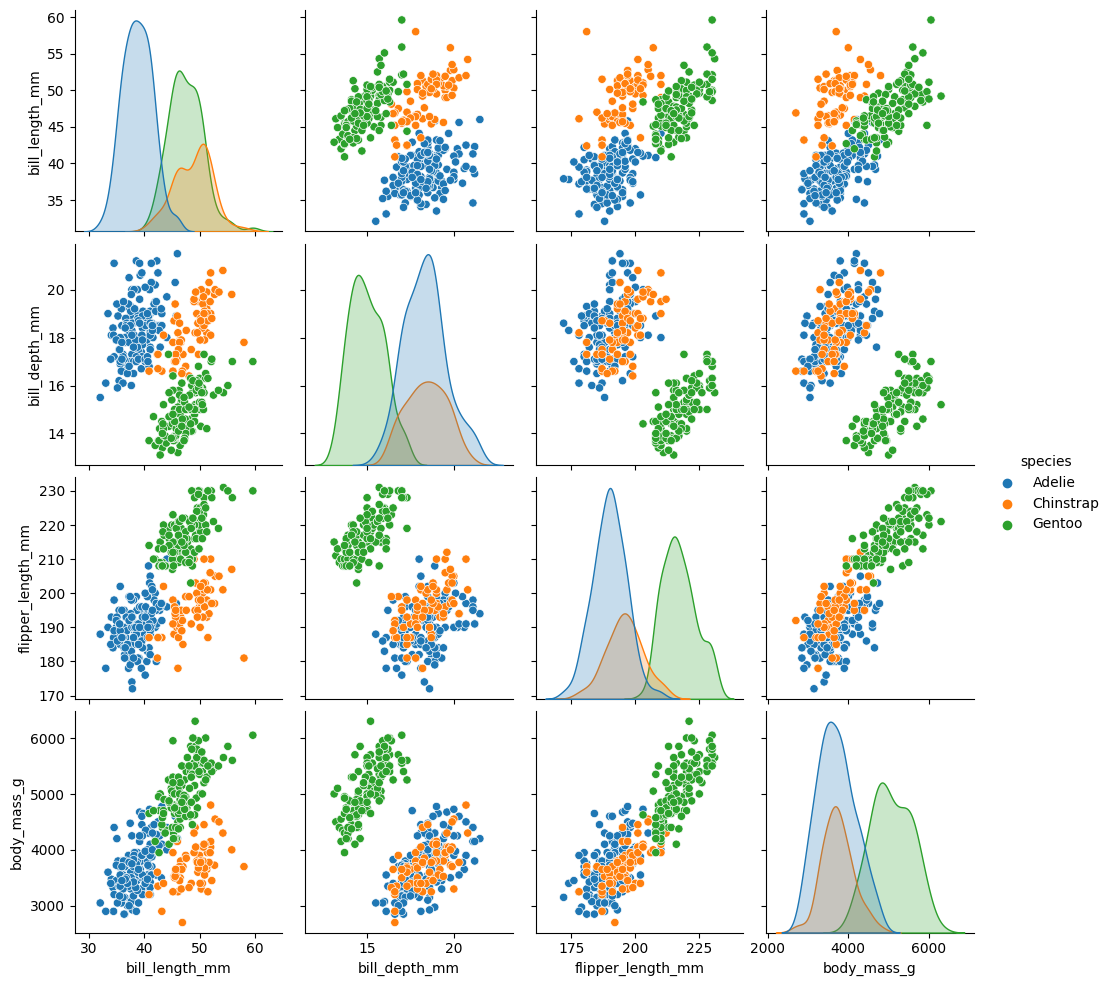

In [4]:
sns.pairplot(data=peng, hue='species')

## Padronização dos dados

Há várias formas de se fazer uma padronização dos dados, uma das mais populares é esta, que deixa a variável com média zero e desvio padrão 1.

In [5]:
padronizador = StandardScaler()
peng_pad = padronizador.fit_transform(peng_num)

## Definir o objeto do agrupamento

Como em diversos procedimentos no Python / Scikit Learn, vamos definir um objeto da classe do agrupamento que queremos fazer - isso significa que ele vai ter os métodos e atributos convenientes para o nosso estudo. Vamos indicar neste passo também os parâmetros do algoritmo.

Como de costume, neste passo não colocamos os dados de entrada.

In [6]:
clus = AgglomerativeClustering(linkage="complete", 
                                 distance_threshold = None, 
                                 n_clusters=3)

## Treinar o algoritmo

Agora sim indicamos os dados, o algoritmo roda, e no objeto criado ficam as informações pertinentes, como por exemplo o rótulo dos grupos para cada linha do *data frame*..

In [7]:
clus.fit(peng_pad)


AgglomerativeClustering(linkage='complete', n_clusters=3)

## Marcando a base original

Primeiramente vamos marcar os rótulos na base de treinamento utilizando o atributo ```labels_``` do objeto de agrupamento. Em seguida vamos colocar essa informação na tabela original.

In [8]:
peng_num['grupo'] = clus.labels_
peng_num.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,grupo
id,,,,,
0,39.1,18.7,181.0,3750.0,1
1,39.5,17.4,186.0,3800.0,1
2,40.3,18.0,195.0,3250.0,1
4,36.7,19.3,193.0,3450.0,1
5,39.3,20.6,190.0,3650.0,1



Lembrando que removemos valores missing, o que tem impacto com a ordem das linhas da tabela. Assim, precisamos fazer um *left join* usando como chave o *index* da base original, o qual demos um nome logo que carregamos os dados, especialmente para poder executar este passo.

In [9]:
peng = peng.merge(peng_num['grupo'], how='left', on='id')

In [10]:
peng.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,grupo
id,,,,,,,,
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,1.0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,1.0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,1.0
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,1.0


## Visualizando os grupos

Fazendo o gráfico original, mas pintando pelos grupos, a impressão visual de identificação de padrões é muito boa. Aparentemente conseguimos identificar muito bem grupos de pinguins semelhantes dentro do grupo, mas diferentes entre grupos.

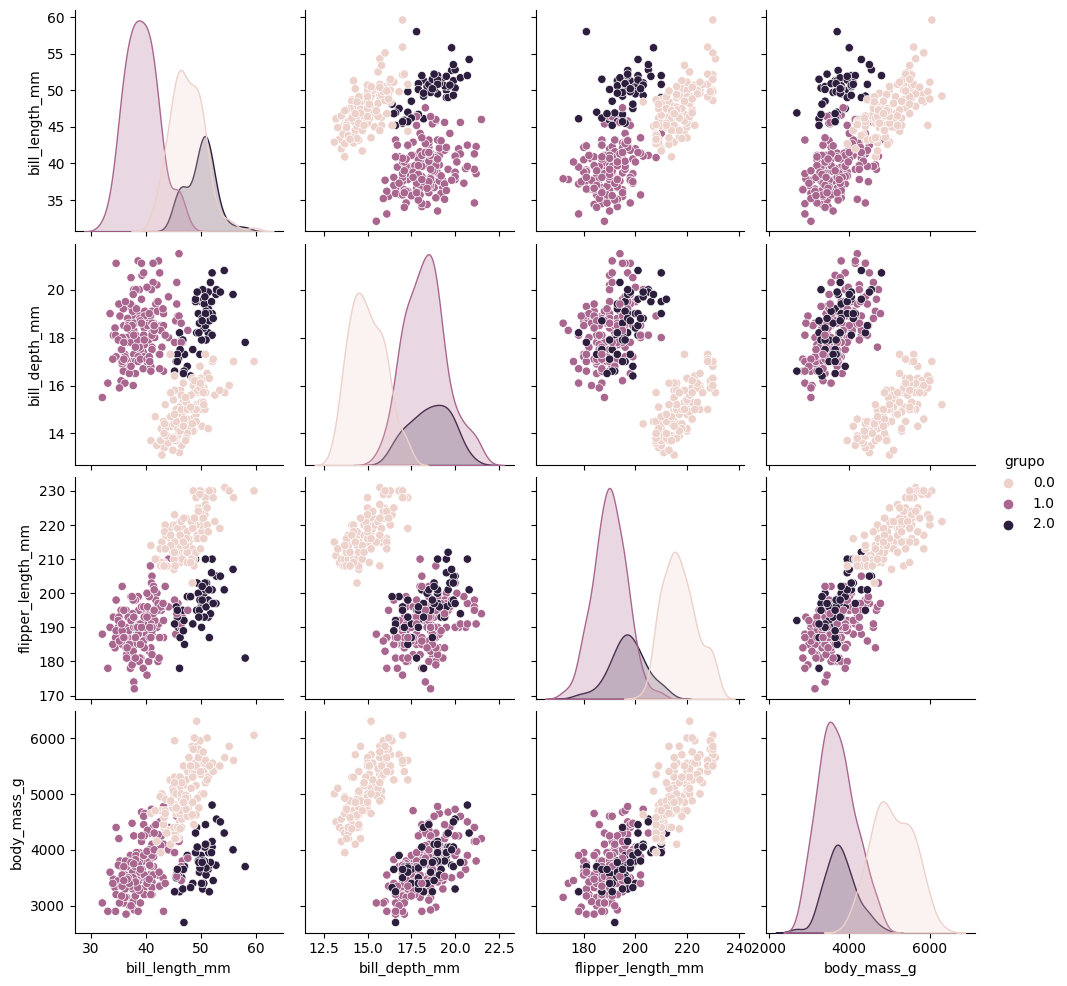

In [11]:
sns.pairplot(data=peng, hue='grupo')

In [12]:
pd.crosstab(peng['species'], peng['grupo'])

grupo,0.0,1.0,2.0
species,,,
Adelie,0,151,0
Chinstrap,0,14,54
Gentoo,123,0,0


## Algoritmo

Vamos discutir o algoritmo e rodar passo a passo, para podermos ter uma sensibilidade e uma ideia intuitiva do seu funcionamento. Tipicamente esse entendimento ajuda muito a entendermos as diferenças entre algoritmos, suas características, quando roda bem e quando não, e por fim, ajuda a decidir qual algoritmo usar no problema que temos na nossa frente.

A ideia básica do algoritmo é a seguinte:

1. Calcular as distâncias para todos os pares de pontos da nossa tabela. Isso significa calcular $(n^2-n)/2$ distâncias.<br>
    Calcular todas as distâncias significa calcular uma matriz de distâncias entre cada par de pontos. A matriz de distâncias vai ter essa cara:

<div>
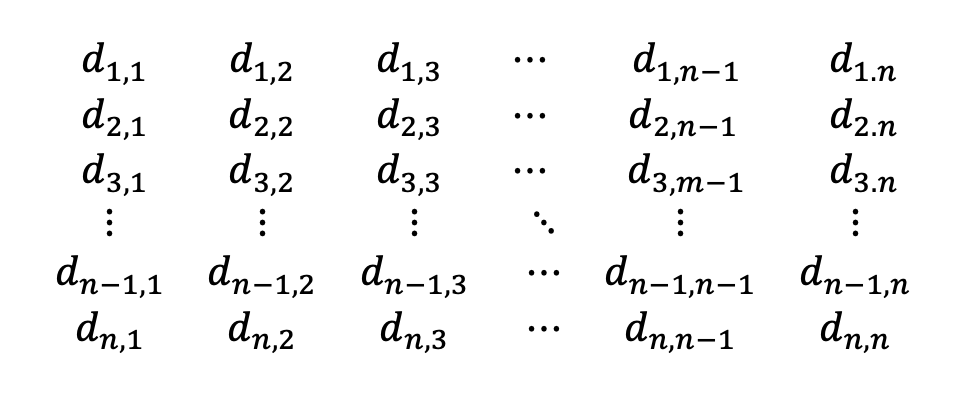
</div>
em que $d_{i, j}$ é a distância entre o ponto i e o ponto j.
<br>

2. Encontrar a menor distância <br>
    $d_{min} = min_{i, j}(d_{i,j}) $ <br>
    com $i \ne j$<br><br>

3. Agrupar o par correspondente à menor distância. Ou seja, recalcular as distâncias desse novo 'ponto' a todos os demais.

<div>
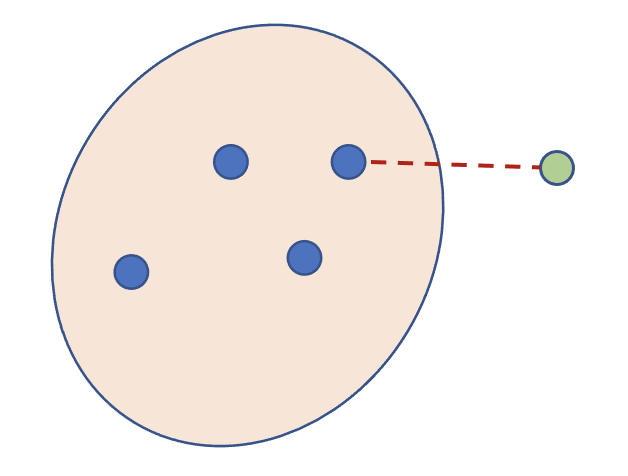
</div>

3. Repetir 2 e 3 até agrupar todos os elementos em um grande agrupamento.




Repare que como $d_{i, j}$ = $d_{j, i}$, a matriz de distâncias fica com essa cara:

<div>
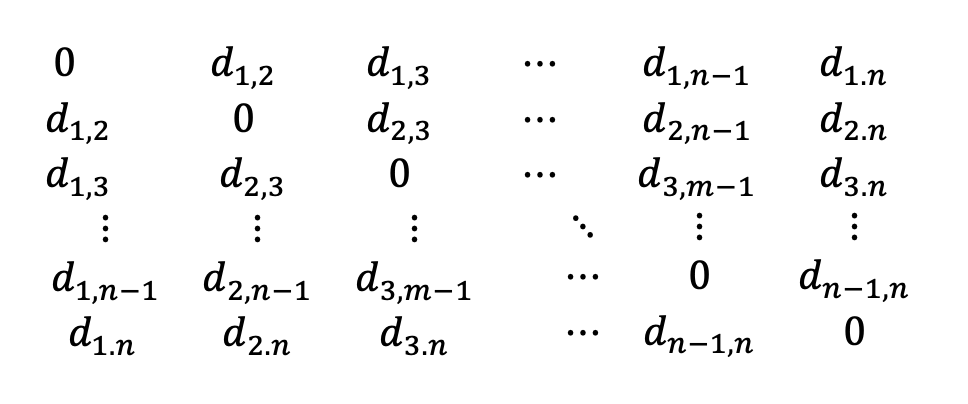
</div>

## Gerando os dados

Vamos começar gerando 12 pontos com variáveis ```x``` e ```y```, com um agrupamento natural identificavel visualmente. Vamos fazer o gráfico passo a passo para ir acompanhando o algoritmo.

In [13]:
## Gerar os dados
np.random.seed(2360873)
x = np.random.normal([1, 2, 3]*4,.2,12)
y = np.random.normal([0, 2, 0]*4,.2,12)
pontos = pd.DataFrame(np.c_[x,y], columns = ['x', 'y'])
pontos

,x,y
0,0.808025,0.002214
1,1.836726,1.864276
2,3.144988,0.150698
3,1.185140,-0.074400
4,2.135976,2.195185
5,2.707983,0.015969
6,0.989527,0.187312
7,1.795878,1.957112
8,2.496841,0.041325
9,0.965620,0.339734


## Fazer o gráfico

Vamos fazer o gráfico, identificando cada ponto pelo rótulo, dando uma cor para cada grupo. Inicialmente, cada ponto pertence a seu próprio grupo, então teremos 12 cores.

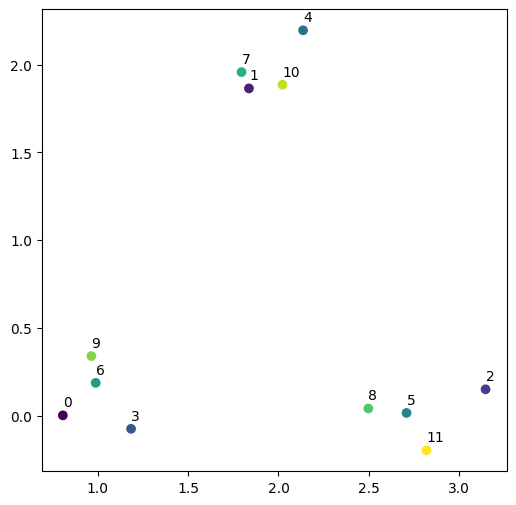

In [14]:
# Fazer o gráfico
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)

cores = pontos.index.values
ax.scatter(pontos['x'], pontos['y'], c=cores)

for idx, col in pontos.iterrows():
     ax.annotate(idx, (col['x'], col['y']+.05) )

## Calcular as distâncias

Vamos calcular as distâncias para todos os pares de pontos.

In [15]:
d = pd.DataFrame(distance.cdist(pontos, pontos, 'euclidean'))

## Menor distância

Vamos identificar os dois pontos mais próximos através da menor distância entre eles.

In [16]:
D = d[d!=0].copy()
D.style.highlight_min(axis = None).format(precision=2, decimal=',')

,0,1,2,3,4,5,6,7,8,9,10,11
0,nan,"2,13","2,34","0,38","2,56","1,90","0,26","2,19","1,69","0,37","2,24","2,02"
1,"2,13",nan,"2,16","2,05","0,45","2,04","1,88","0,10","1,94","1,76","0,19","2,28"
2,"2,34","2,16",nan,"1,97","2,28","0,46","2,16","2,25","0,66","2,19","2,07","0,48"
3,"0,38","2,05","1,97",nan,"2,46","1,53","0,33","2,12","1,32","0,47","2,13","1,64"
4,"2,56","0,45","2,28","2,46",nan,"2,25","2,31","0,42","2,18","2,19","0,33","2,49"
5,"1,90","2,04","0,46","1,53","2,25",nan,"1,73","2,14","0,21","1,77","1,99","0,24"
6,"0,26","1,88","2,16","0,33","2,31","1,73",nan,"1,94","1,51","0,15","1,99","1,87"
7,"2,19","0,10","2,25","2,12","0,42","2,14","1,94",nan,"2,04","1,82","0,24","2,38"
8,"1,69","1,94","0,66","1,32","2,18","0,21","1,51","2,04",nan,"1,56","1,90","0,40"
9,"0,37","1,76","2,19","0,47","2,19","1,77","0,15","1,82","1,56",nan,"1,87","1,93"


## Agrupar os elementos respectivos

Para agrupar os elementos, vamos identificar os índices e "recalcular" a matriz de distâncias. Claro que não precisamos recalcular tudo, mas somente as distâncias ao novo elemento agrupado. Há várias formas de fazer esse cálculo que é o que chamamos de **método de agregação**. Vamos utilizar um bastante popular que é o ***complete linkage*** (ou ligação completa), que consiste em definir a distância de um ponto qualquer $p_j$ à unidade recém agregada como o mínimo entre as distância entre o ponto $p_j$ e cada um dos pontos da unidade agregada.

In [17]:
D.min().min()

0.10142537250432097

In [18]:
# Identificar índices dos elementos a serem agrupados
juntar = set(D.loc[:,D.min() == D.min().min()].columns)
juntar

{1, 7}

## Gráfico intermediário

O gráfico abaixo vai mostrar como 'está' o agrupamento neste passo, agora devemos ter uma cor a menos, pois dois pontos vão estar agrupados.

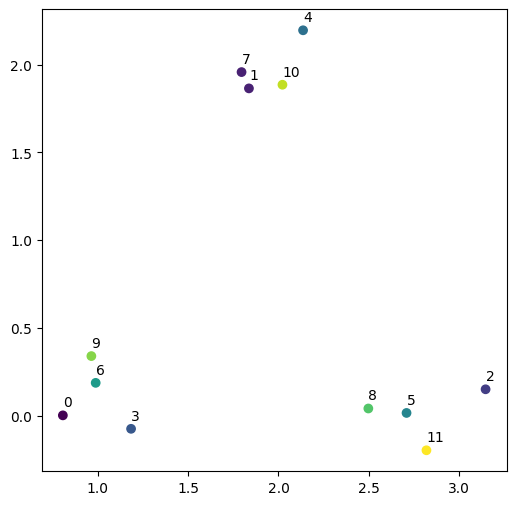

In [19]:
cores[(cores == max(juntar)) | (cores == min(juntar))] = min(juntar)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)

ax.scatter(pontos['x'], pontos['y'], c=cores)

for idx, col in pontos.iterrows():
     ax.annotate(idx, (col['x'], col['y']+.05) )

## Matriz de distâncias

Calcular novamente a matriz de distâncias e encontrar o *próximo* para a ser agregado.

In [20]:
D.loc[:,min(list(juntar))] = d[list(juntar)].min(axis=1)
D.loc[min(list(juntar))] = d[list(juntar)].min(axis=1).replace(0,np.nan)
D.drop(columns = juntar - {min(juntar)}, index = juntar - {min(juntar)}, inplace=True)

D.style.highlight_min(axis=None)


,0,1,2,3,4,5,6,8,9,10,11
0,nan,2.127323,2.341675,0.384819,2.563704,1.900008,0.259238,1.689269,0.372500,2.240290,2.019802
1,2.127323,nan,2.155898,2.045245,0.415145,2.043361,1.878817,1.938788,1.755863,0.186419,2.282617
2,2.341675,2.155898,nan,1.972732,2.279919,0.457302,2.155771,0.657310,2.187550,2.066217,0.477036
3,0.384819,2.045245,1.972732,nan,2.460712,1.525522,0.326737,1.316796,0.468717,2.130701,1.637443
4,2.563704,0.415145,2.279919,2.460712,nan,2.253036,2.312120,2.183881,2.193725,0.330387,2.487178
5,1.900008,2.043361,0.457302,1.525522,2.253036,nan,1.726977,0.212659,1.772188,1.991030,0.239403
6,0.259238,1.878817,2.155771,0.326737,2.312120,1.726977,nan,1.514366,0.154286,1.987058,1.868365
8,1.689269,1.938788,0.657310,1.316796,2.183881,0.212659,1.514366,nan,1.560027,1.903930,0.399730
9,0.372500,1.755863,2.187550,0.468717,2.193725,1.772188,0.154286,1.560027,nan,1.871900,1.928489
10,2.240290,0.186419,2.066217,2.130701,0.330387,1.991030,1.987058,1.903930,1.871900,nan,2.228744


## Função

Como vamos repetir esses passos diversas vezes, vamos transformá-los em funções para facilitar a nossa vida.

In [21]:
def acha_indice(D, pontos, cores):
    juntar = set(D.loc[:,D.min() == D.min().min()].columns)

    cores[(cores == max(juntar)) | (cores == min(juntar))] = min(juntar)

    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(1,1,1)

    ax.scatter(pontos['x'], pontos['y'], c=cores)

    for idx, col in pontos.iterrows():
         ax.annotate(idx, (col['x'], col['y']+.05) )
    print(juntar)

    return juntar



In [22]:
def agrupar(D, d, juntar):
    D.loc[:,min(list(juntar))] = d[list(juntar)].min(axis=1)
    D.loc[min(list(juntar))] = d[list(juntar)].min(axis=1).replace(0,np.nan)
    D.drop(columns = juntar - {min(juntar)}, index = juntar - {min(juntar)}, inplace=True)

    display(D.style.highlight_min(axis=None))
    return D


### Passo 2

{9, 6}


,0,1,2,3,4,5,6,8,10,11
0,nan,2.127323,2.341675,0.384819,2.563704,1.900008,0.259238,1.689269,2.240290,2.019802
1,2.127323,nan,2.155898,2.045245,0.415145,2.043361,1.755863,1.938788,0.186419,2.282617
2,2.341675,2.155898,nan,1.972732,2.279919,0.457302,2.155771,0.657310,2.066217,0.477036
3,0.384819,2.045245,1.972732,nan,2.460712,1.525522,0.326737,1.316796,2.130701,1.637443
4,2.563704,0.415145,2.279919,2.460712,nan,2.253036,2.193725,2.183881,0.330387,2.487178
5,1.900008,2.043361,0.457302,1.525522,2.253036,nan,1.726977,0.212659,1.991030,0.239403
6,0.259238,1.755863,2.155771,0.326737,2.193725,1.726977,nan,1.514366,1.871900,1.868365
8,1.689269,1.938788,0.657310,1.316796,2.183881,0.212659,1.514366,nan,1.903930,0.399730
10,2.240290,0.186419,2.066217,2.130701,0.330387,1.991030,1.871900,1.903930,nan,2.228744
11,2.019802,2.282617,0.477036,1.637443,2.487178,0.239403,1.868365,0.399730,2.228744,nan


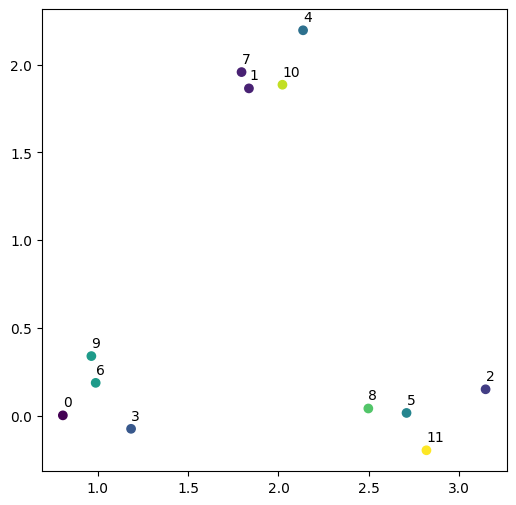

In [23]:
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

### Passo 3

{1, 10}


,0,1,2,3,4,5,6,8,11
0,nan,2.127323,2.341675,0.384819,2.563704,1.900008,0.259238,1.689269,2.019802
1,2.127323,nan,2.066217,2.045245,0.330387,1.991030,1.878817,1.903930,2.228744
2,2.341675,2.066217,nan,1.972732,2.279919,0.457302,2.155771,0.657310,0.477036
3,0.384819,2.045245,1.972732,nan,2.460712,1.525522,0.326737,1.316796,1.637443
4,2.563704,0.330387,2.279919,2.460712,nan,2.253036,2.193725,2.183881,2.487178
5,1.900008,1.991030,0.457302,1.525522,2.253036,nan,1.726977,0.212659,0.239403
6,0.259238,1.878817,2.155771,0.326737,2.193725,1.726977,nan,1.514366,1.868365
8,1.689269,1.903930,0.657310,1.316796,2.183881,0.212659,1.514366,nan,0.399730
11,2.019802,2.228744,0.477036,1.637443,2.487178,0.239403,1.868365,0.399730,nan


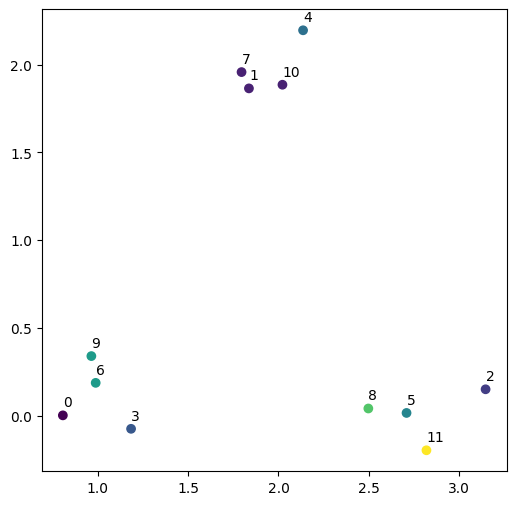

In [24]:
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

### Passo 4

{8, 5}


,0,1,2,3,4,5,6,11
0,nan,2.127323,2.341675,0.384819,2.563704,1.689269,0.259238,2.019802
1,2.127323,nan,2.066217,2.045245,0.330387,1.938788,1.878817,2.228744
2,2.341675,2.066217,nan,1.972732,2.279919,0.457302,2.155771,0.477036
3,0.384819,2.045245,1.972732,nan,2.460712,1.316796,0.326737,1.637443
4,2.563704,0.330387,2.279919,2.460712,nan,2.183881,2.193725,2.487178
5,1.689269,1.938788,0.457302,1.316796,2.183881,nan,1.514366,0.239403
6,0.259238,1.878817,2.155771,0.326737,2.193725,1.514366,nan,1.868365
11,2.019802,2.228744,0.477036,1.637443,2.487178,0.239403,1.868365,nan


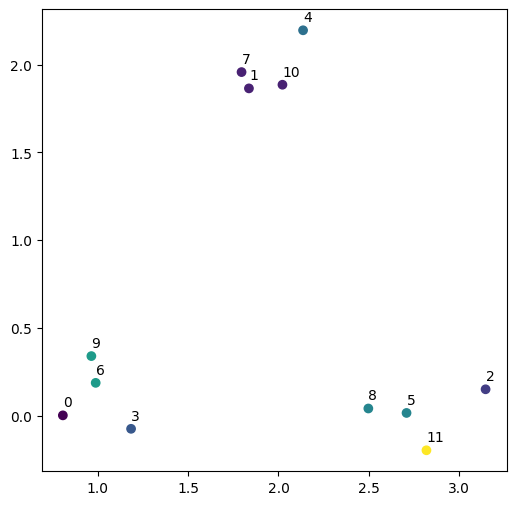

In [25]:
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

### Passo 5

{11, 5}


,0,1,2,3,4,5,6
0,nan,2.127323,2.341675,0.384819,2.563704,1.900008,0.259238
1,2.127323,nan,2.066217,2.045245,0.330387,2.043361,1.878817
2,2.341675,2.066217,nan,1.972732,2.279919,0.457302,2.155771
3,0.384819,2.045245,1.972732,nan,2.460712,1.525522,0.326737
4,2.563704,0.330387,2.279919,2.460712,nan,2.253036,2.193725
5,1.900008,2.043361,0.457302,1.525522,2.253036,nan,1.726977
6,0.259238,1.878817,2.155771,0.326737,2.193725,1.726977,nan


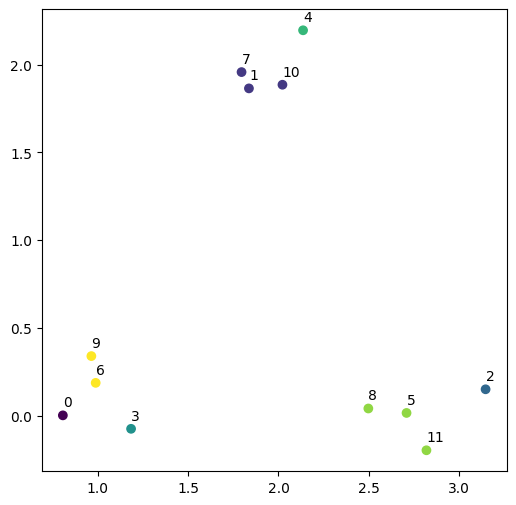

In [26]:
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

### Passo 6

{0, 6}


,0,1,2,3,4,5
0,nan,1.878817,2.155771,0.326737,2.312120,1.726977
1,1.878817,nan,2.066217,2.045245,0.330387,2.043361
2,2.155771,2.066217,nan,1.972732,2.279919,0.457302
3,0.326737,2.045245,1.972732,nan,2.460712,1.525522
4,2.312120,0.330387,2.279919,2.460712,nan,2.253036
5,1.726977,2.043361,0.457302,1.525522,2.253036,nan


array([0, 1, 2, 3, 4, 5, 0, 1, 5, 0, 1, 5])

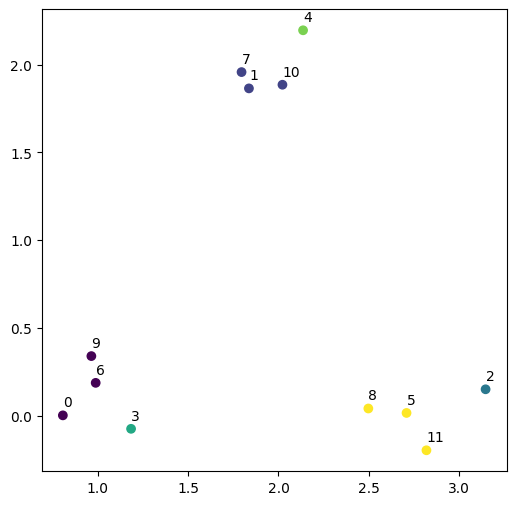

In [27]:
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)
cores

### Passo 7

{0, 3}


,0,1,2,4,5
0,nan,2.045245,1.972732,2.460712,1.525522
1,2.045245,nan,2.066217,0.330387,2.043361
2,1.972732,2.066217,nan,2.279919,0.457302
4,2.460712,0.330387,2.279919,nan,2.253036
5,1.525522,2.043361,0.457302,2.253036,nan


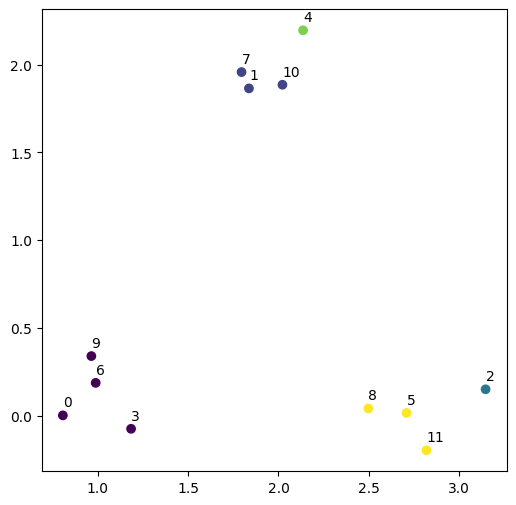

In [28]:
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

### Passo 8

{1, 4}


,0,1,2,5
0,nan,2.127323,1.972732,1.525522
1,2.127323,nan,2.155898,2.043361
2,1.972732,2.155898,nan,0.457302
5,1.525522,2.043361,0.457302,nan


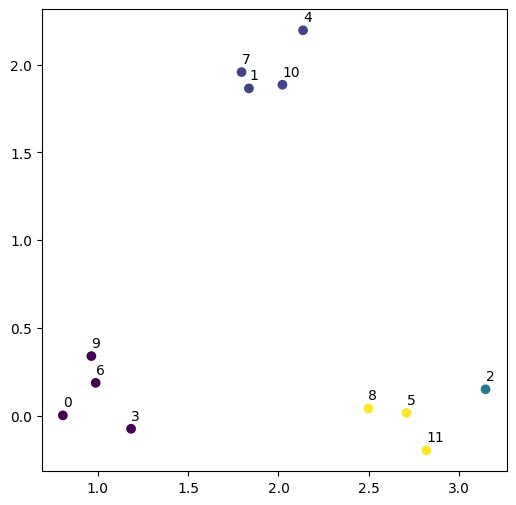

In [29]:
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

### Passo 9

{2, 5}


,0,1,2
0,nan,2.127323,1.900008
1,2.127323,nan,2.043361
2,1.900008,2.043361,nan


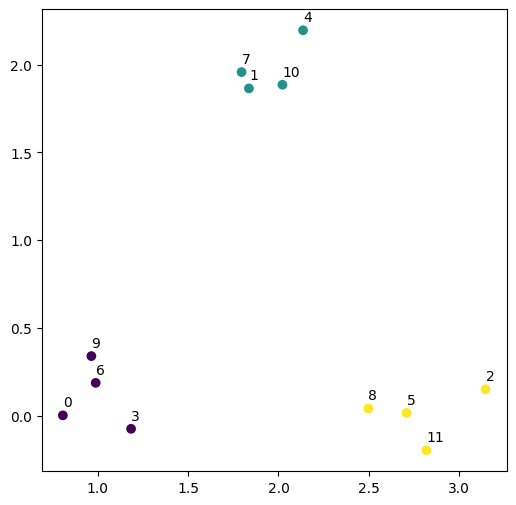

In [30]:
#juntar
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

### Passo 10

{0, 2}


,0,1
0,nan,2.127323
1,2.127323,nan


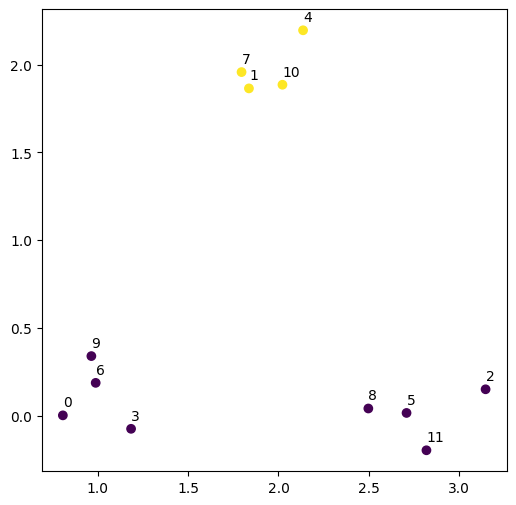

In [31]:
#juntar
juntar = acha_indice(D, pontos, cores)
D = agrupar(D, d, juntar)

## Dendrograma

Essa palavrinha esquisita vem do grego, *déndron* que significa árvore, então dendrograma é um diagrama de árvore. É uma técnica muito popular nesse tipo de agrupamento para ajudar a escolher o número de grupos a se utilizar através de um gráfico bem simpático.

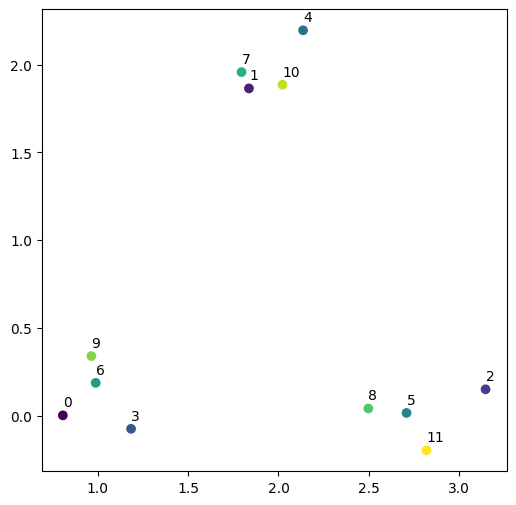

In [32]:
## Gerar os dados
np.random.seed(2360873)
x = np.random.normal([1, 2, 3]*4,.2,12)
y = np.random.normal([0, 2, 0]*4,.2,12)
pontos = pd.DataFrame(np.c_[x,y], columns = ['x', 'y'])
pontos

# Fazer o gráfico
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)

cores = pontos.index.values
ax.scatter(pontos['x'], pontos['y'], c=cores)

for idx, col in pontos.iterrows():
     ax.annotate(idx, (col['x'], col['y']+.05) )

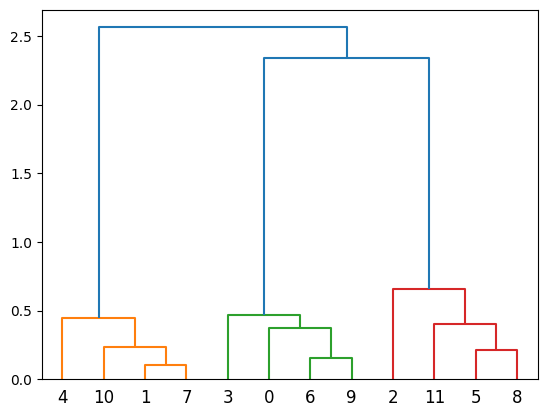

In [33]:
dend = shc.dendrogram(shc.linkage(pontos, method='complete'))

In [34]:
peng = sns.load_dataset('penguins')
peng.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [35]:
df = peng.select_dtypes('number').dropna()
df_pad = StandardScaler().fit_transform(df)

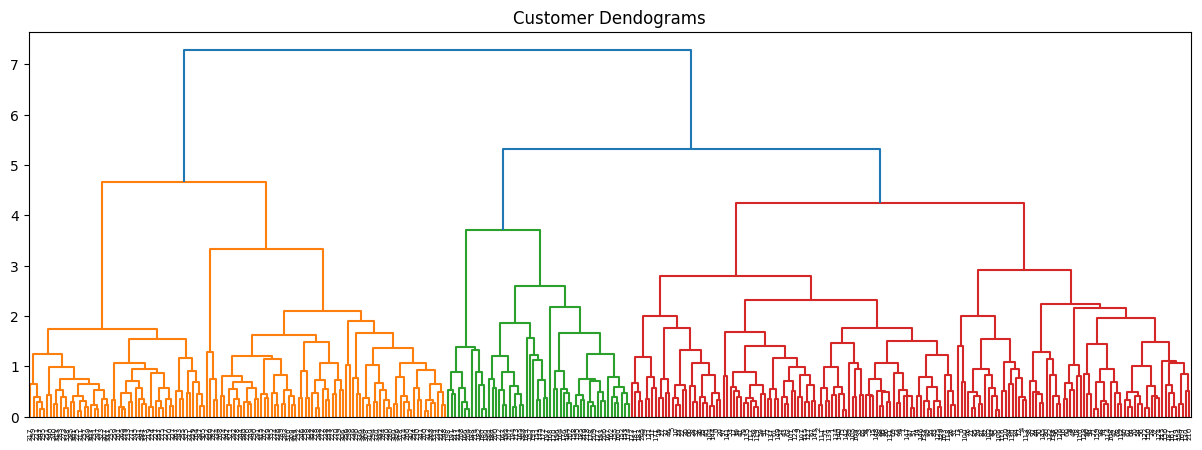

In [37]:
plt.figure(figsize=(15, 5))

plt.title("Customer Dendograms")

dend = shc.dendrogram(shc.linkage(df_pad, method='complete'))

## Tipos de ligação

O tipo de ligação é a forma como vamos conectar um elemento a um conjunto de pontos já agrupados. Este elemento pode ser um ponto ou outro agrupamento de pontos. Há várias formas de se definir este critério, vamos discutir algumas e suas características.

## Parâmetros do algoritmo - Tipos de ligação

| | |
|:-:|:-:|
|***Single linkage*** (ligação simples): a distância de um ponto ao cluster é o mínimo entre todas as distâncias do ponto a cada ponto do grupo.| ***Complete linkage*** (ligação completa): A distância de um ponto ao cluste é o máximo entre todas as distâncias do ponto a cada ponto do grupo. |
|<div>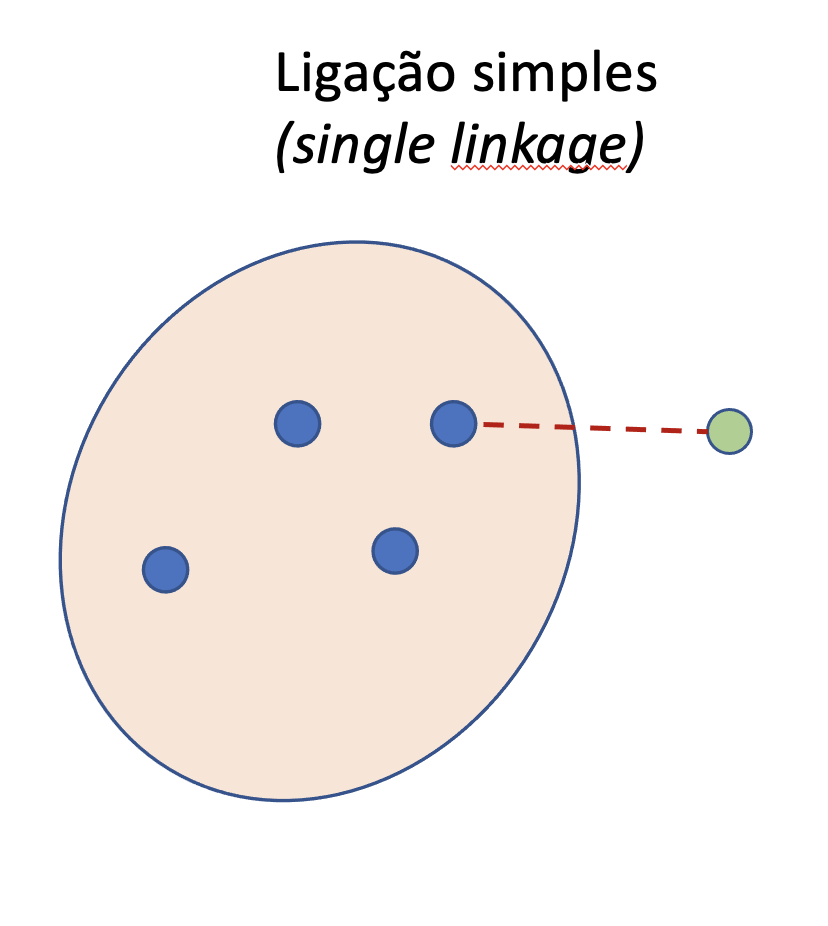</div> | <div>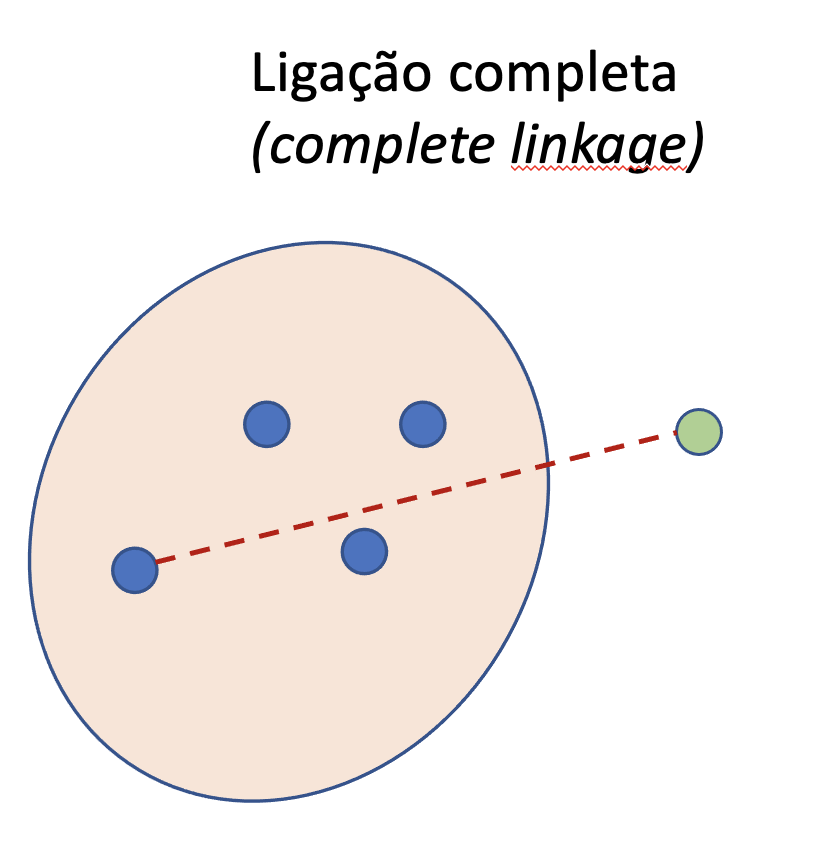</div>|
|***Average linkage*** (Ligação média): A distância de um ponto ao cluster é a média entre todas as distâncias do ponto ao grupo | ***Ward linkage*** (ligação Ward): Esse método se baseia na soma de quadrados das distâncias (SQD) de cada ponto ao centróide do seu respectivo grupo. A distância entre dois clusters se define como o aumento na SQD se juntarmos esses dois grupos.|
|<div>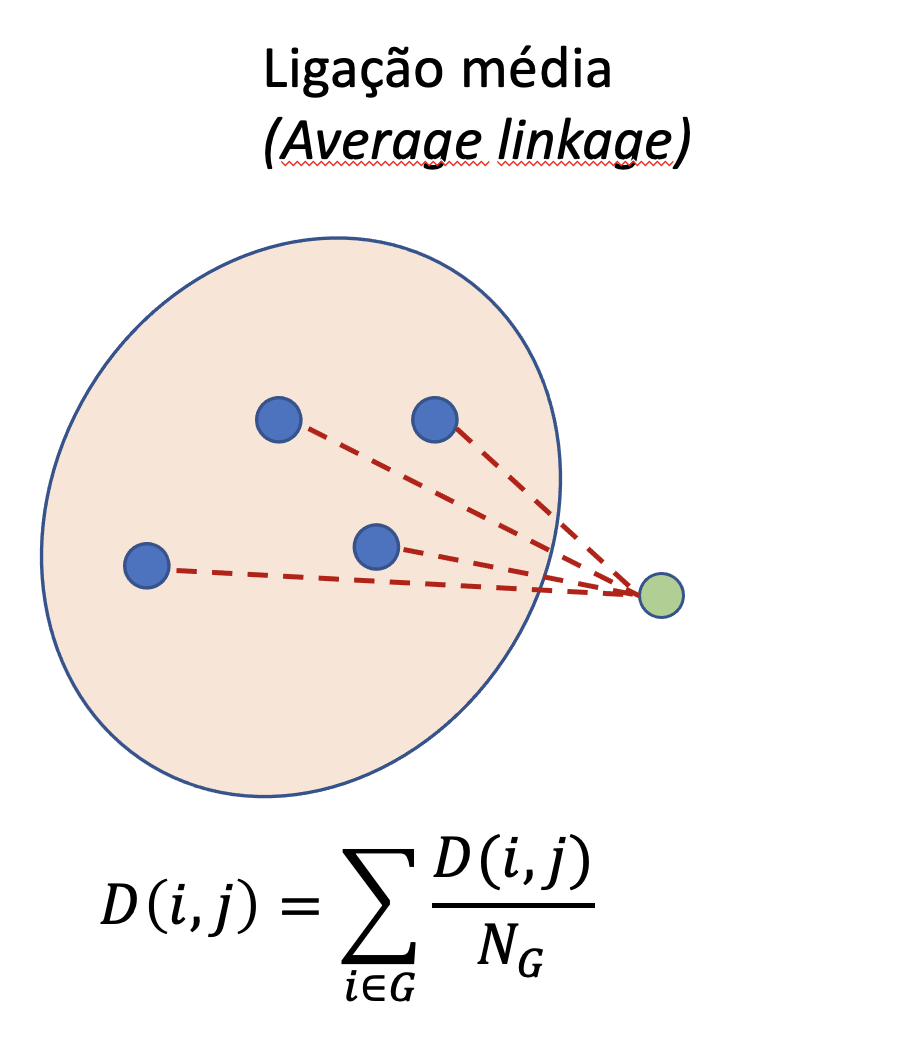</div>|<div>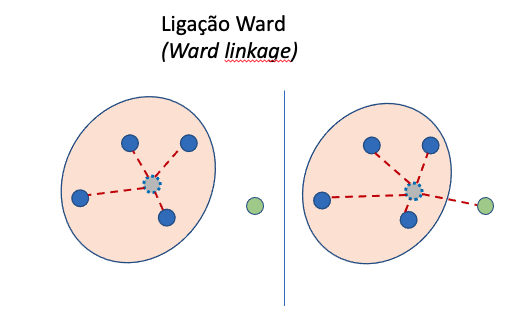</div> |


<!-- 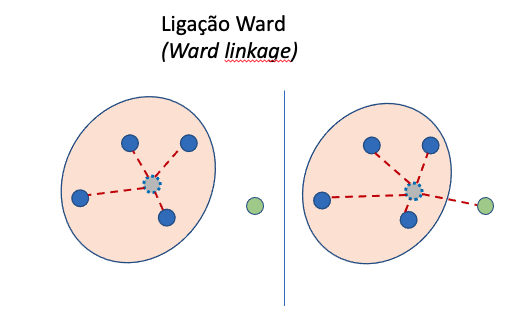 -->
<!-- ![image-4.png](attachment:image-4.png) -->

## Dados sintéticos

https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-hierarchical-clustering

In [39]:
X1, Y1 = datasets.make_moons(n_samples=400,
                  noise=0.05,
                  random_state=2360873)

X2, Y2  = datasets.make_circles(n_samples=390, noise=0.01,factor=0.5)

X3, Y3 = datasets.make_blobs(n_samples=380, random_state=12345)

X4, Y4 = datasets.make_blobs(n_samples=450, random_state=12345)
X4 = np.dot(X4, [[1, 2], [2, 2]])

X = [X1, X2, X3, X4]
Y = [Y1, Y2, Y3, Y4]

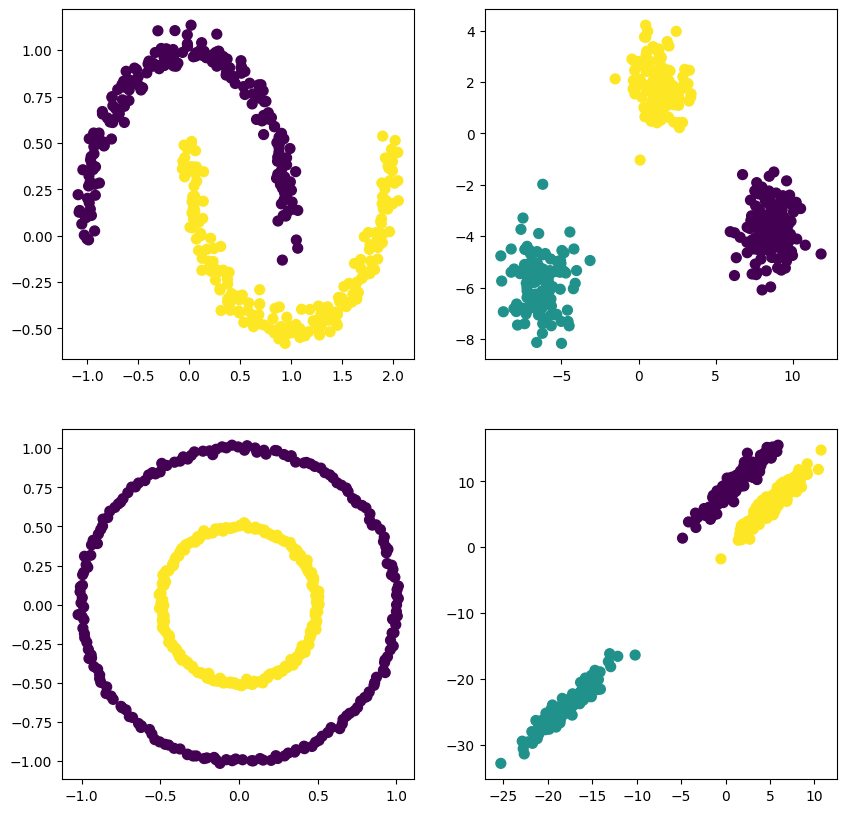

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

for i in range(4):
    ax[i%2,i//2].scatter(X[i][:,0],X[i][:,1], c = Y[i], marker="o", s=50);


In [46]:
ls = []
lc = []
lm = []
wd = []
km = []

mt = [ls, lc, lm, wd, km]
metodos = ['single', 'complete', 'average', 'ward', 'k-means']

for i in range(4):
    for j in range(4):
        mt[j].append(AgglomerativeClustering(n_clusters=len(np.unique(Y[i])), linkage=metodos[j]).fit(X[i]))

for i in range(4):
    mt[4].append(KMeans(n_clusters=len(np.unique(Y[i])), n_init='auto').fit(X[i]))
    


In [47]:
mt

[[AgglomerativeClustering(linkage='single'),
  AgglomerativeClustering(linkage='single'),
  AgglomerativeClustering(linkage='single', n_clusters=3),
  AgglomerativeClustering(linkage='single', n_clusters=3)],
 [AgglomerativeClustering(linkage='complete'),
  AgglomerativeClustering(linkage='complete'),
  AgglomerativeClustering(linkage='complete', n_clusters=3),
  AgglomerativeClustering(linkage='complete', n_clusters=3)],
 [AgglomerativeClustering(linkage='average'),
  AgglomerativeClustering(linkage='average'),
  AgglomerativeClustering(linkage='average', n_clusters=3),
  AgglomerativeClustering(linkage='average', n_clusters=3)],
 [AgglomerativeClustering(),
  AgglomerativeClustering(),
  AgglomerativeClustering(n_clusters=3),
  AgglomerativeClustering(n_clusters=3)],
 [KMeans(n_clusters=2, n_init='auto'),
  KMeans(n_clusters=2, n_init='auto'),
  KMeans(n_clusters=3, n_init='auto'),
  KMeans(n_clusters=3, n_init='auto')]]

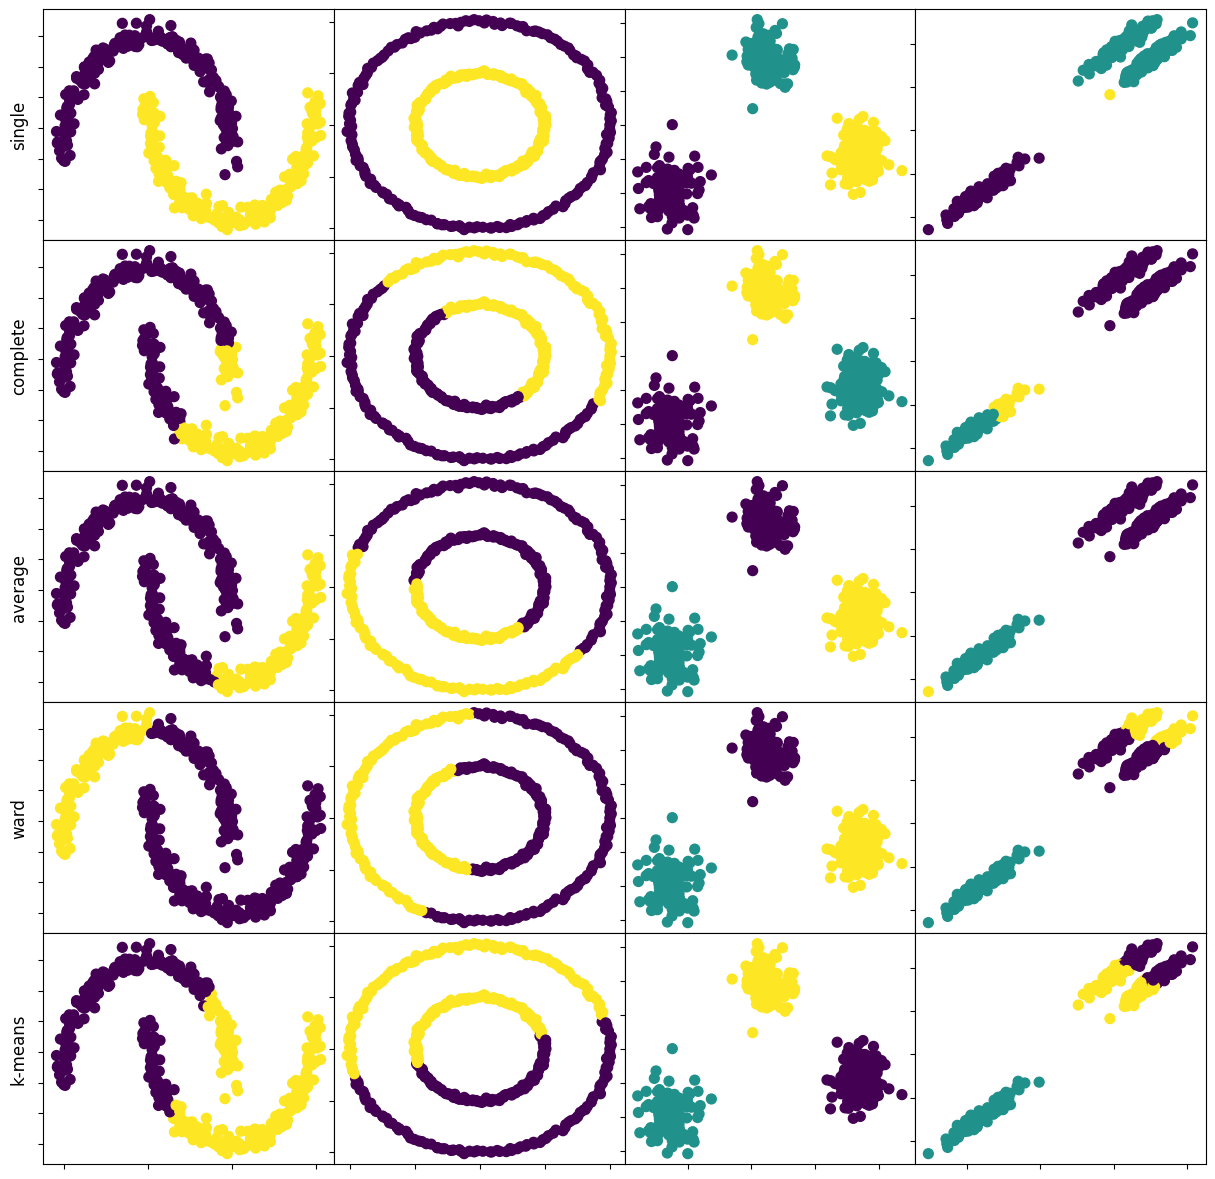

In [48]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(15,15))

for i in range(4):
    # Desativar rótulos dos eixos
    
    for j in range(5):
        ax[j,i].scatter(X[i][:,0],X[i][:,1], c = mt[j][i].labels_, marker="o", s=50);
        
        ax[j,i].set_yticklabels([])
        ax[j,i].set_xticklabels([])
        if i==0:
            ax[j,i].set_ylabel(metodos[j], fontsize='large')
        
    
plt.subplots_adjust(wspace=0, hspace=0)



## Trabalhando com dados mistos

Precisamos de uma definição de distância que acomode dados qualitativos como:

- Sexo
- Raça do pinguim
- Tipo de cartão etc

## Distâncias

Podemos usar diversos tipos de distância para rodar o nosso algoritmo. Vamos comentar algumas que terão efeito prático sobre os nossos próximos passos:

- Distância euclidiana: a distância mais intuitiva e comum de se utilizar para variáveis quantitativas.
- Distância Manhattan: É a distância percorrida entre dois pontos quando só se anda na vertical ou na horizontal. Tem vantagens para se calcular, e é utilizada na distância de Gower.
- Distância dice: é uma medida de distância para dados qualitativos. É baseada na quantidade de características em comum entre duas observações.
- Distância de Gower: É popular para a realização de agrupamentos com variáveis binárias e contínuas na mesma tabela. Ela conjuga a distância de Dice para variáveis discretas e distância Manhattan para variáveis contínuas.

| | |
|:-:|:-:|
| Distância Euclidiana | Distância de Manhattan |
| <div>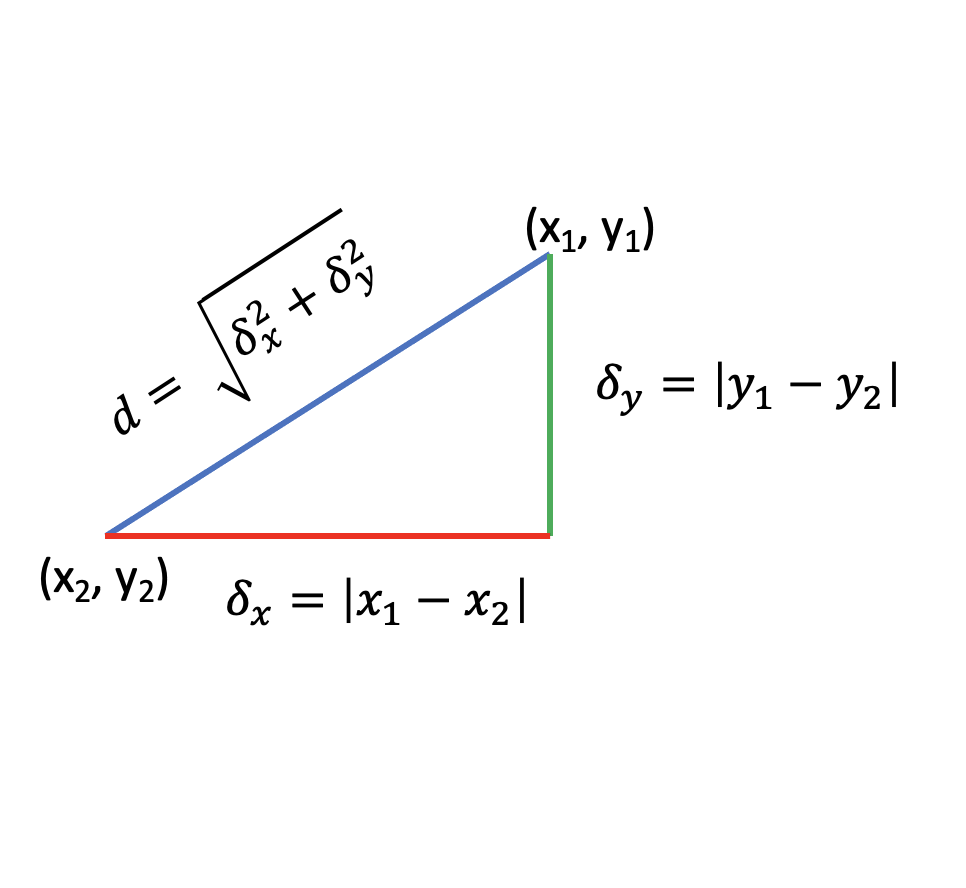</div> | <div>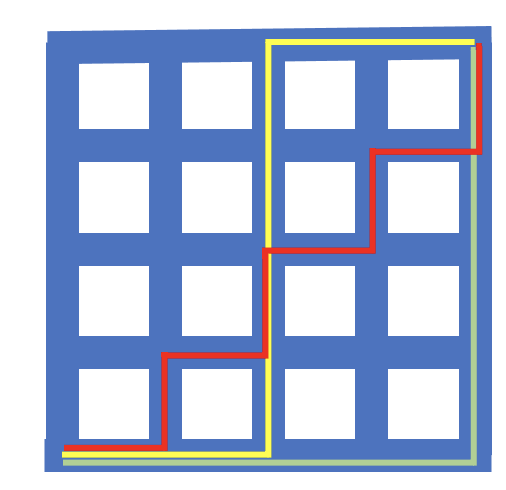</div> |
| Distância Dice | Distância de Gower |
| <div>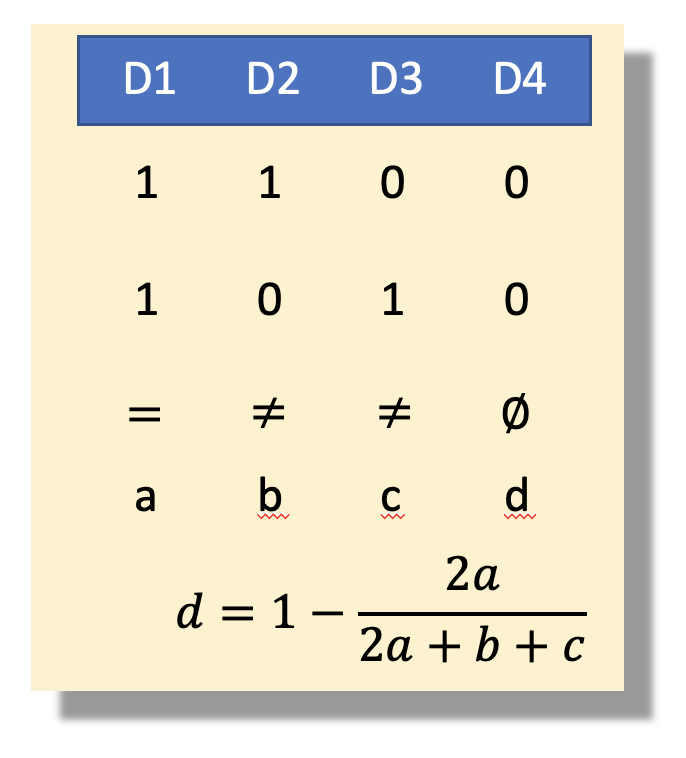</div> | <div>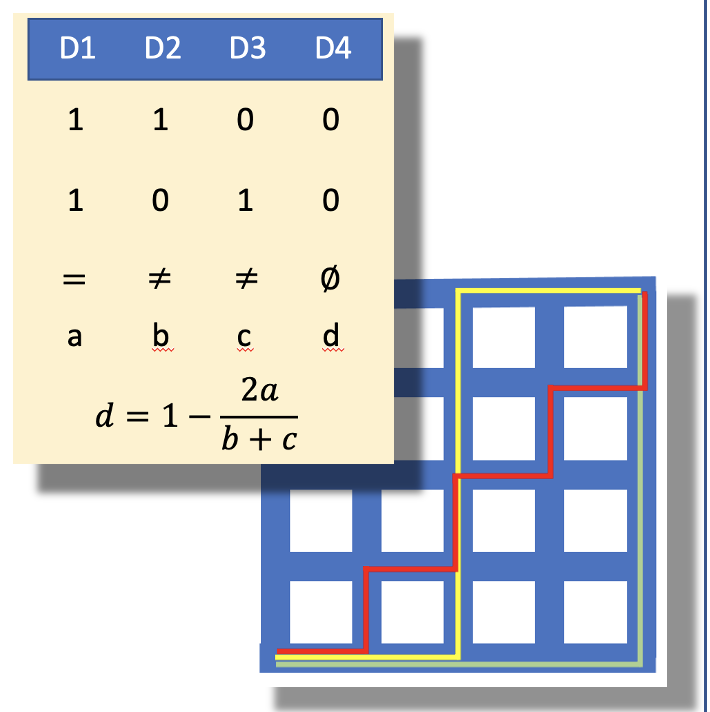</div> |


# Tipos de dados misturados

Vamos fazer uma aplicação em uma base, misturando dados categorizados e dados numéricos utilizando a distância de Gower.

Os métodos hierárquicos podem ser executados tendo como input a matriz de distâncias, e é isso que vamos fazer. Antes de começar é importante planejar os passos a serem seguidos, então vamos fazer isso. Vamos executar os seguintes passos:

- Tratamento de dados:
    - Missing: decidir o que fazer com eles. Eliminar ou preencher?
    - Criar *dummies* para dados categorizados
    - Identificar variáveis *dummy*
- Calcular a matriz de distâncias com o método de Gower
- Executar o agrupamento hierárquico a partir dessa matriz
- Avaliar os agrupamentos

## Carregar os dados

In [51]:
pg = sns.load_dataset('penguins')

## Tratamento de dados

Aqui, precisamos decidir o que fazer com dados não preenchidos. 

- Os dados quantitativos não preenchidos tem uma resposta mais ou menos óbvia: removê-los. Digo isto porque há apenas dois registros com dados não preenchidos, e todas as variáveis quantitativas estão sem preenchimento para essas duas observações.

- Dados discretos não preenchidos: aqui já dá mais pra discutir o que fazer. Há mais registros sem o preenchimento de sexo. Talvez a determinação do sexo de um pinguim não seja trivial em determinadas situações. Podemos adotar duas posturas:
    - Eliminar os dados com valores faltantes: os prós são a velocidade e o pragmatismo, os contras são a eliminação de dados, e que podemos continuar com o mesmo problema se quisermos aplicar o modelo para indivíduos fora da amostra.
    - Preencher com o valor modal ou um valor aleatório: o ponto pró é o aproveitamento dos dados dos indivíduos com as demais variáveis preenchidas, o ponto contra é a introdução de ruído no modelo.
    - Preenchimento por modelo (ex: por random forest): pontos pró são aproveitamento das observações, introdução reduzida de ruído, ter um método para aplicação em outras amostras. Pontos contra: tempo de desenvolvimento e aumento da complexidade do modelo.

In [52]:
pg.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [53]:
variaveis = pg.columns.values[2:]
variaveis_cat = variaveis[-1]

In [54]:
pg2 = pd.get_dummies(pg[variaveis].dropna())
pg2.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_Female,sex_Male
0,39.1,18.7,181.0,3750.0,0,1
1,39.5,17.4,186.0,3800.0,1,0
2,40.3,18.0,195.0,3250.0,1,0
4,36.7,19.3,193.0,3450.0,1,0
5,39.3,20.6,190.0,3650.0,0,1


In [55]:
pg2.columns.values

array(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'sex_Female', 'sex_Male'], dtype=object)

In [56]:
vars_cat = [True if x in {'sex_Male', 'sex_Female'} else False for x in pg2.columns]

In [57]:
vars_cat

[False, False, False, False, True, True]

In [58]:
pg2.shape

(333, 6)

## Calculando as distâncias

A função ```gower_matrix``` calcula a matriz de distâncias utilizando a distância de Gower. Como já vimos, essa distância é a distância 'dice' para variáveis categorizadas e a distância 'Manhattan' para variáveis contínuas.

Como as variáveis categorizadas estão em formato de *dummy* (elas **tem** que estar como *dummy*), precisamos indicar para o algoritmo quais são as variáveis categorizadas. Vamos fazer isso no parâmetro ```cat_features```.

In [59]:
distancia_gower = gower_matrix(pg2, cat_features=vars_cat)

In [60]:
distancia_gower[:5, :5]

array([[0.        , 0.37799034, 0.41719112, 0.40757075, 0.06896389],
       [0.37799034, 0.        , 0.06763994, 0.09064583, 0.4162814 ],
       [0.41719112, 0.06763994, 0.        , 0.06252081, 0.42362407],
       [0.40757075, 0.09064583, 0.06252081, 0.        , 0.3926184 ],
       [0.06896389, 0.4162814 , 0.42362407, 0.3926184 , 0.        ]],
      dtype=float32)

Precisamos ajustar o formato da matriz de distâncias para alimentar o algoritmo com este objeto. Vamos fazer isso com a função ```squareform``` do numpy.

In [61]:
gdv = squareform(distancia_gower,force='tovector')

In [62]:
gdv.shape

(55278,)

## Treinando o agrupamento

Agora vamos usar a função ```linkage``` do scipy, indicando o método como *complete*, para rodar este algoritmo com a matriz de distâncias indicada. Em seguida, por uma questão de conveniência, vamos transformar o objeto com o modelo 'treinado' em um *data frame*.

In [63]:
Z = linkage(gdv, method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df.head()

,id1,id2,dist,n
0,31.0,101.0,0.005951,2.0
1,42.0,46.0,0.006061,2.0
2,220.0,304.0,0.007730,2.0
3,254.0,305.0,0.007730,2.0
4,260.0,295.0,0.008170,2.0


## Dendrograma

Uma outra forma de fazer o dendrograma é com a função ```dendrogram``` do scipy, que recebe a informação do próprio objeto do agrupamento.

Leaves = 333


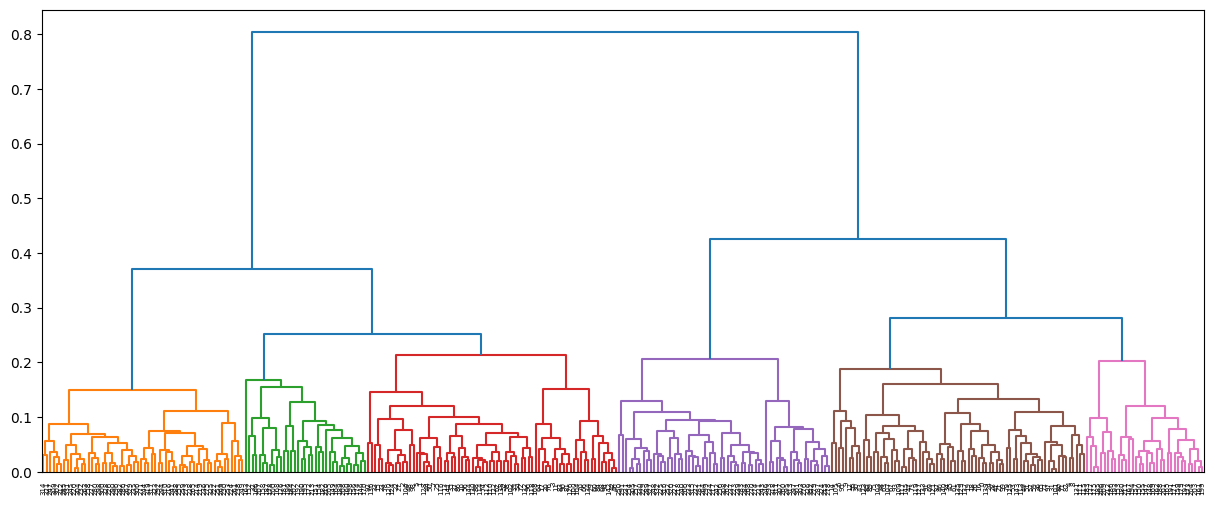

In [64]:
fig,axs = plt.subplots(1,1,figsize=(15,6))
dn = dendrogram(Z, truncate_mode='level',p=30,show_leaf_counts=True,ax=axs, color_threshold=.24)
print(f"Leaves = {len(dn['leaves'])}")

Vamos marcar os grupos na tabela original e fazer uma rápida inspeção para identificar os grupos.

In [65]:
pg2['grupo'] = fcluster(Z, 6, criterion='maxclust')
pg2.grupo.value_counts()

5    73
3    72
4    61
1    58
2    35
6    34
Name: grupo, dtype: int64

Vamos fazer uma análise descritiva agora dos grupos, e tentar identificar as características deles quanto a espécie e sexo do pinguim.

In [66]:
pg3 = pg.reset_index().merge(pg2.reset_index(), how='left')
pg3.groupby(['sex', 'species', 'grupo'])['index'].count().unstack().fillna(0).style.format(precision=0)

## Classificando os grupos

É comum, em projetos de agrupamentos, precisarmos de um procedimento que classifica novas observações aos grupos que obtivemos.

No *k-means* podemos adotar um critério de classificação natural utilizando o ```.fit()```, que vai avaliar a distância da nova observação a cada um dos centróides, e classificar naquele grupo que resultar a menor distância. Mas e nos métodos hierárquicos? Você consegue pensar em como classificar novas observações?

Bem, não há um método natural. Mas você pode utilizar todos os algoritmos de classificação que já conhece para fazer a classificação dos métodos hierárquicos, como a regressão logística, árvore de classificação, random forest etc. Pode utilizar as mesmas técnicas de *cross-validation* para garantir a qualidade e tudo. Uma característica é que a acurácia costuma ser bem razoável, pois os grupos procuram ser definidos como função dos dados, o que deve facilitar um pouco as coisas para o algoritmo de classificação.

In [68]:
pg3.columns

# selecionar variáveis explicativas (features) e eliminar missings
X = pg3.dropna()[['bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex_Female', 'sex_Male']]

# Selecionar variável resposta (target)
y = pg3.dropna()['grupo']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2360873)

In [70]:
clf = RandomForestClassifier(random_state=2360873, n_estimators=50)

grid_parametros = {'ccp_alpha':np.arange(0, .1, .01)}


In [71]:
np.arange(0, .1, .01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

In [72]:
grid = GridSearchCV(estimator = clf, param_grid=grid_parametros, cv=4, verbose=100)
grid.fit(X_train, y_train) 

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4; 1/10] START ccp_alpha=0.0..............................................
[CV 1/4; 1/10] END ...............ccp_alpha=0.0;, score=0.985 total time=   0.0s
[CV 2/4; 1/10] START ccp_alpha=0.0..............................................
[CV 2/4; 1/10] END ...............ccp_alpha=0.0;, score=0.985 total time=   0.0s
[CV 3/4; 1/10] START ccp_alpha=0.0..............................................
[CV 3/4; 1/10] END ...............ccp_alpha=0.0;, score=1.000 total time=   0.0s
[CV 4/4; 1/10] START ccp_alpha=0.0..............................................
[CV 4/4; 1/10] END ...............ccp_alpha=0.0;, score=1.000 total time=   0.0s
[CV 1/4; 2/10] START ccp_alpha=0.01.............................................
[CV 1/4; 2/10] END ..............ccp_alpha=0.01;, score=1.000 total time=   0.0s
[CV 2/4; 2/10] START ccp_alpha=0.01.............................................
[CV 2/4; 2/10] END ..............ccp_alpha=0.01;

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_estimators=50,
                                              random_state=2360873),
             param_grid={'ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])},
             verbose=100)

In [73]:
grid.best_params_

{'ccp_alpha': 0.01}

In [74]:
resultados = pd.DataFrame(grid.cv_results_)
resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.037306,0.002464,0.003018,0.000212,0.0,{'ccp_alpha': 0.0},0.985075,0.985075,1.000000,1.0,0.992537,0.007463,7
1,0.036488,0.000596,0.002870,0.000121,0.01,{'ccp_alpha': 0.01},1.000000,0.985075,1.000000,1.0,0.996269,0.006463,1
2,0.035983,0.000795,0.002797,0.000130,0.02,{'ccp_alpha': 0.02},1.000000,0.985075,1.000000,1.0,0.996269,0.006463,1
3,0.035614,0.000275,0.002720,0.000143,0.03,{'ccp_alpha': 0.03},1.000000,0.985075,1.000000,1.0,0.996269,0.006463,1
4,0.036282,0.000428,0.002843,0.000079,0.04,{'ccp_alpha': 0.04},1.000000,0.985075,1.000000,1.0,0.996269,0.006463,1
5,0.037034,0.000637,0.002878,0.000156,0.05,{'ccp_alpha': 0.05},1.000000,0.985075,1.000000,1.0,0.996269,0.006463,1
6,0.036513,0.000407,0.002769,0.000064,0.06,{'ccp_alpha': 0.06},1.000000,0.985075,1.000000,1.0,0.996269,0.006463,1
7,0.036467,0.000999,0.002778,0.000107,0.07,{'ccp_alpha': 0.07},1.000000,0.985075,0.984848,1.0,0.992481,0.007520,8
8,0.035537,0.000775,0.002681,0.000125,0.08,{'ccp_alpha': 0.08},1.000000,0.985075,0.984848,1.0,0.992481,0.007520,8
9,0.035030,0.000345,0.002589,0.000034,0.09,{'ccp_alpha': 0.09},0.985075,0.985075,0.984848,1.0,0.988749,0.006496,10


In [75]:
clf = RandomForestClassifier(random_state=2360873, n_estimators=50, ccp_alpha=0.01)
clf.fit(X_train,y_train)

RandomForestClassifier(ccp_alpha=0.01, n_estimators=50, random_state=2360873)

In [76]:
clf.score(X_test, y_test)

1.0